# imports

In [32]:
from __future__ import division

In [33]:
%matplotlib notebook
import matplotlib.pyplot as plt
from schlichtanders.mymatplotlib import Centre
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
import pandas as pd
# plt.style.use('ggplot')

In [34]:
import os, platform, sys
from pprint import pprint

In [35]:
__file__ = os.path.realpath('__file__')
if platform.system() == "Windows":
    from schlichtanders.myos import replace_unc
    __file__ = replace_unc(__file__)
__path__ = os.path.dirname(__file__)
__parent__ = os.path.dirname(__path__)

In [36]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float, Boolean
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker, Session, create_session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import operator as op
from collections import defaultdict
import csv
import heapq
from copy import copy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
inf = float('inf')
from sklearn import cross_validation

In [37]:
import experiment_models
import experiment_util
from schlichtanders.mycontextmanagers import ignored
from schlichtanders.myobjects import Namespace, NestedNamespace
from evaluation import get_modes
import evaluation as eva

In [38]:
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
from theano.tensor.shared_randomstreams import RandomStreams
import theano_models.probabilistic_models as pm

In [39]:
import numpy as np
import theano

In [40]:
def fmap_results(f,results, inplace=False):
    new = results if inplace else defaultdict(lambda: defaultdict(dict))
    for test in results:
        for name in results[test]:
            for nn in results[test][name]:
                new[test][name][nn] = f(results[test][name][nn])
    return new

def reduce_results(f, results, acc=0):
    for test in results:
        for name in results[test]:
            for nn in results[test][name]:
                acc = f(acc, results[test][name][nn])
    return acc

In [41]:
model_names = { # sorted by optimization type
    "ml": ['baselinedet', 'baselinedetplus'],
    "annealing": ['baseline', 'baselineplus', 'mixture',
                  'planarflow', 'planarflowdet', 'radialflow', 'radialflowdet'],
    # first trials do not seem to be successfull, furthermore this needs a lot of time, maybe later on
    # "ml_exp_average": ['mixtureml', 'planarflowml', 'radialflowml'],
}
model_prefixes = reduce(op.add, model_names.values())

In [42]:
reload(experiment_util)

<module 'experiment_util' from '/home/stephan/GitProjects/theano_models/experiment/experiment_util.pyc'>

In [43]:
Hyper = experiment_util.get_old_hyper(model_prefixes)

# Dataset identifiers

In [44]:
datasetnames = ["boston", "concrete", "energy", "kin8nm", "powerplant", "winered", "yacht"]
datasetname = "concrete"

data, error_func = experiment_util.load_and_preprocess_data(datasetname)
X, Z, VX, VZ, TX, TZ = data
example_input = X[0]
example_output = Z[0]
output_transfer = "softmax" if datasetname == "mnist" else "identity"
dataset_id = example_input, example_output, output_transfer

# Collect models and find best ones

In [45]:
reload(eva)

<module 'evaluation' from '/home/stephan/GitProjects/theano_models/experiment/__file__'>

In [27]:
n_best = 2
best_hyper = eva.get_best_hyper(["run_windows"], Hyper, model_prefixes,
                                n_best=n_best, test_suffix=["best_val_loss", "val_error_rate"],
                               key = lambda fn, p: datasetname in fn)

In [50]:
def to_pandas_dict(datasetname, best_hyper, pandas_dict=None):
    if pandas_dict is None:
        pandas_dict = defaultdict(list, {
            'datasetname': [],
            'test_measures': [],
            'model': [],
            'n_normflows': [],
        })
    for test in best_hyper:
        for name in best_hyper[test]:
            for nn in best_hyper[test][name]:
                pandas_dict['datasetname'].append(datasetname)
                pandas_dict['test_measures'].append(test)
                pandas_dict['model'].append(name)
                pandas_dict['n_normflows'].append(nn)
                for i, v in enumerate(best_hyper[test][name][nn][0]):
                    vn = "value%i" % i
                    pandas_dict[vn].append(v)
    return pandas_dict

In [58]:
pandas_dict = None
for dn in datasetnames:
    n_best = 3
    _best_hyper = eva.get_best_hyper(["run_windows"], Hyper, model_prefixes,
                                    n_best=n_best, test_suffix=["best_val_loss", "val_error_rate"],
                                   key = lambda fn, p: dn in fn)
    pandas_dict = to_pandas_dict(dn, _best_hyper, pandas_dict)
    print len(pandas_dict['datasetname'])
pd.DataFrame(data=pandas_dict).to_csv(os.path.join(__path__, "all_best_results.csv"))

108
216
324
414
486
594
702


In [16]:
best_hyper

defaultdict(<function evaluation.defaultdictdict>,
            {'best_val_loss': defaultdict(dict,
                         {'baseline': {1: ([2.883494783484417,
                             3.218217335576597],
                            [hyper 8789966523545, hyper 8789966523561]),
                           2: ([2.4686542842699133, 2.727057631119438],
                            [hyper 8789966623101, hyper 8789966623205]),
                           3: ([2.67841449405836, 2.7496158682781715],
                            [hyper 8789966523465, hyper 8789966523449]),
                           4: ([4.1184674511785095, 4.21223083164381],
                            [hyper 8789966523441, hyper 8789966523425]),
                           8: ([2.0464404064676036, 2.4654262929722885],
                            [hyper 8789966523577, hyper 8789966349701]),
                           20: ([2.7365072499150815, 2.8814868650574614],
                            [hyper 8789966401985, hyper 8789966

In [16]:
best_hyper['best_val_loss']['baseline'][1][1][0].datasetname

u'boston'

# Compute Results on Test-set

In [21]:
reload(eva)
reload(experiment_models)
reload(experiment_util)

<module 'experiment_models' from '/home/stephan/GitProjects/theano_models/experiment/experiment_models.pyc'>

In [18]:
# for computing test results
pm.RNG = NestedNamespace(tm.PooledRandomStreams(pool_size=int(1e8)), RandomStreams())

In [ ]:
test_results = eva.compute_test_results(
    best_hyper, lambda hyper: experiment_util.load_and_preprocess_data(hyper.datasetname),
    model_module_id=dataset_id, n_trials=10
)

mixture
boston
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
boston
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
boston
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
boston
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
boston
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
boston
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
boston
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [18]:
%debug

> /home/stephan/GitProjects/theano_models/experiment/evaluation.py(295)compute_test_results()
    294                     with open(save_path, "wb") as f:
--> 295                         pickle.dump(best_tests, f, -1)
    296 

ipdb> best_tests
defaultdict(<function defaultdictdicttuplelist at 0x7f62652ba140>, {'best_val_loss': defaultdict(<function defaultdicttuplelist at 0x7f623bb3faa0>, {'mixture': defaultdict(<function <lambda> at 0x7f623bb3f8c0>, {1: ([array([ 8.23423559,         inf,  6.95714244,  6.50250922,         inf,
        7.36699134,         inf,  5.63306209,  3.82080184,  5.83668084])], [array([ 3.01906663,  2.80353994,  3.30633235,  3.37524373,  3.26466431,
        3.52364363,  2.92344437,  3.39354258,  3.15725894,  3.36753215])], [array([220,   0,  22,  18,   0,   5,   0,   1,   1,  22])], [array([ array([ 1.06210616, -0.5805661 , -0.56697718, ...,  0.08906215,
        0.09221752,  0.11492646]),
       None,
       array([ -7.13784882e-03,  -6.97158554e-01,  -6.0980106

In [186]:
test_results

NameError: name 'test_results' is not defined

# Sample the approximate posterior distribution for evaluation

In [95]:
reload(eva)

<module 'evaluation' from '/home/stephan/GitProjects/theano_models/experiment/__file__'>

In [ ]:
best_hyper_samples = eva.sample_best_hyper(best_hyper, model_module_id=dataset_id)

In [103]:
# best_hyper_samples only refers to hypers which distribution can be compared (i.e. baselinedet and such is removed)
test_attrs = sorted(best_hyper_samples.keys())
model_prefixes = sorted(best_hyper_samples[test_attrs[0]].keys())
n_normflows = sorted(best_hyper_samples[test_attrs[0]][model_prefixes[0]].keys())

lp = len(model_prefixes)
lnn = len(n_normflows)

## number of modes / histogram of modes

In [99]:
nr_modes = eva.get_nr_modes(best_hyper_samples, threshold_d=50)
nr_modes

defaultdict(<function evaluation.defaultdictdict>,
            {'best_val_loss': defaultdict(dict,
                         {'baseline': {1: Counter({1: 1502}),
                           2: Counter({1: 1502}),
                           3: Counter({1: 1502}),
                           4: Counter({1: 1502}),
                           8: Counter({1: 1502}),
                           20: Counter({1: 1502})},
                          'mixture': {1: Counter({1: 1502}),
                           2: Counter({1: 1501, 2: 1}),
                           3: Counter({1: 1480, 2: 19, 3: 3}),
                           4: Counter({1: 1467, 2: 35}),
                           8: Counter({1: 1501, 2: 1}),
                           20: Counter({1: 1488, 2: 14})},
                          'planarflow': {1: Counter({1: 1502}),
                           2: Counter({1: 1502}),
                           3: Counter({1: 1502}),
                           4: Counter({1: 1502}),
                     

In [93]:
nr_modes = eva.get_nr_modes(best_hyper_samples)
nr_modes

defaultdict(<function evaluation.defaultdictdict>,
            {'best_val_loss': defaultdict(dict,
                         {'baseline': {1: Counter({1: 1501, 2: 1}),
                           2: Counter({1: 1501, 2: 1}),
                           3: Counter({1: 1502}),
                           4: Counter({1: 1502}),
                           8: Counter({1: 1502}),
                           20: Counter({1: 1502})},
                          'mixture': {1: Counter({1: 1502}),
                           2: Counter({1: 1501, 2: 1}),
                           3: Counter({1: 1474, 2: 24, 3: 4}),
                           4: Counter({1: 1459, 2: 43}),
                           8: Counter({1: 1497, 2: 5}),
                           20: Counter({1: 1477, 2: 24, 3: 1})},
                          'planarflow': {1: Counter({1: 1502}),
                           2: Counter({1: 1502}),
                           3: Counter({1: 1502}),
                           4: Counter({1: 1502}),
   

## Correlations between parameters

In [100]:
reload(eva)

<module 'evaluation' from '/home/stephan/GitProjects/theano_models/experiment/__file__'>

In [181]:
correlations = eva.get_best_correlations(best_hyper_samples)

In [184]:
best_hyper['best_val_loss']['planarflow'][20]

([None, inf], [hyper 8727367328093, hyper 8727367328245])

In [172]:
def vmax(acc, a):
    return max(acc, a.max())
def vmin(acc, a):
    return min(acc, a.min())

In [173]:
correlations0 = fmap_results(lambda x: abs(x[0]), correlations)
correlations0_vmax = -inf
correlations0_vmin = inf
correlations0_vmax = reduce_results(vmax, correlations0, correlations0_vmax)
correlations0_vmin = reduce_results(vmin, correlations0, correlations0_vmin)

In [178]:
n_normflows

[1, 2, 3, 4, 8, 20]

In [177]:
model_prefixes

['baseline',
 'mixture',
 'planarflow',
 'planarflowdet',
 'radialflow',
 'radialflowdet']

<IPython.core.display.Javascript object>


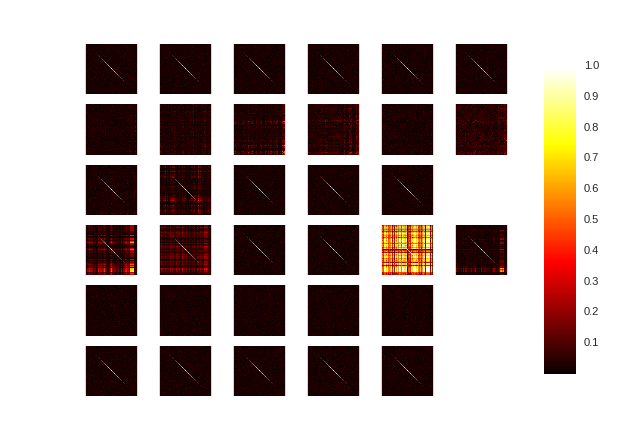

<IPython.core.display.Javascript object>


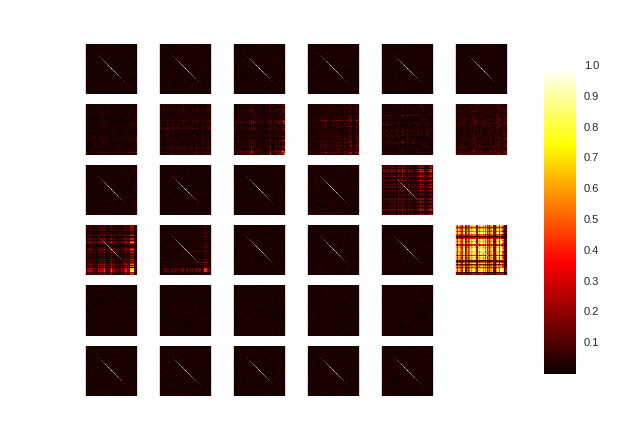

In [174]:
# only correlations from best one
for test in test_attrs:
    fig, axs = plt.subplots(ncols=len(n_normflows), nrows=len(model_prefixes), sharex=True, sharey=True)
    axs_iter = axs.flat
    for name in model_prefixes:
        for nn in n_normflows:
            ax = next(axs_iter)
            ax.grid(False)
            ax.axis("off")
            try:
                im = ax.imshow(correlations0[test][name][nn],
                               vmax=correlations0_vmax, vmin=correlations0_vmin, cmap=plt.cm.hot) #, norm=Centre()
            except KeyError:  # radialflow has some problems
                pass
            
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
#     fig.tight_layout()
#     plt.axis('off')

## alternative plots for correlations

In [175]:
correlations1 = fmap_results(lambda x: abs(x[1]), correlations)
correlations1_vmax = -inf
correlations1_vmin = inf
correlations1_vmax = reduce_results(vmax, correlations1, correlations1_vmax)
correlations1_vmin = reduce_results(vmin, correlations1, correlations1_vmin)

<IPython.core.display.Javascript object>


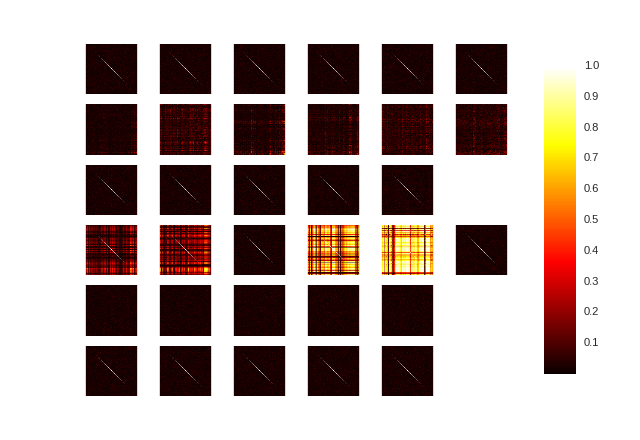

<IPython.core.display.Javascript object>


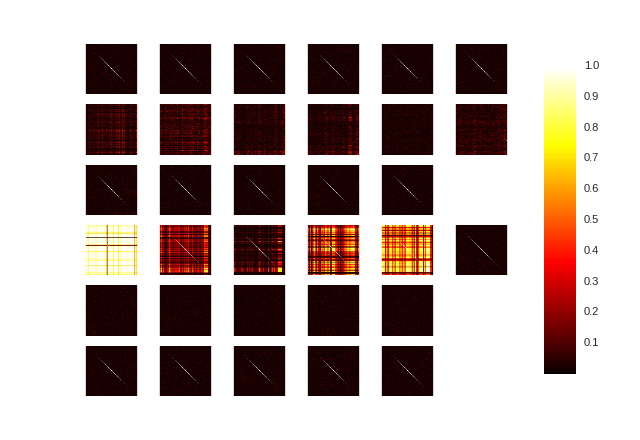

In [176]:
# only correlations from best one
for test in test_attrs:
    fig, axs = plt.subplots(ncols=len(n_normflows), nrows=len(model_prefixes), sharex=True, sharey=True)
    axs_iter = axs.flat
    for name in model_prefixes:
        for nn in n_normflows:
            ax = next(axs_iter)
            ax.grid(False)
            ax.axis("off")
            try:
                im = ax.imshow(correlations1[test][name][nn],
                               vmax=correlations1_vmax, vmin=correlations1_vmin, cmap=plt.cm.hot) #, norm=Centre()
            except KeyError:  # radialflow has some problems
                pass
            
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
#     fig.tight_layout()
#     plt.axis('off')

In [160]:
correlations_ = fmap_results(lambda x: abs(np.array(x)), correlations)
means = fmap_results(lambda x: x.mean(axis=0), correlations_)
variances = fmap_results(lambda x: x.var(axis=0), correlations_)
means_vmax = -inf
means_vmin = inf
variances_vmax = -inf
variances_vmin = 0

variances_vmax = reduce_results(vmax, variances, variances_vmax)
variances_vmin = reduce_results(vmin, variances, variances_vmin)
means_vmax = reduce_results(vmax, means, means_vmax)
means_vmin = reduce_results(vmin, means, means_vmin)

<IPython.core.display.Javascript object>


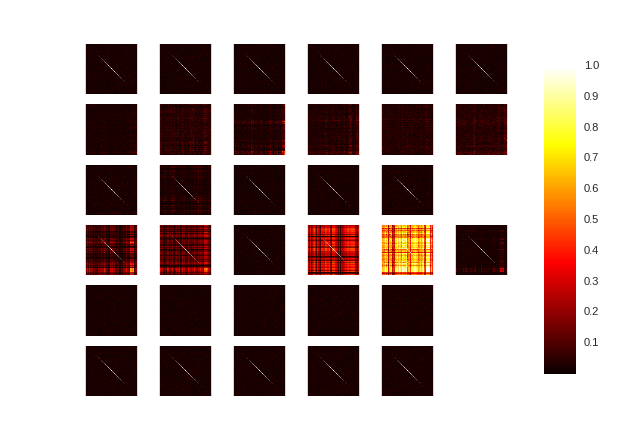

<IPython.core.display.Javascript object>


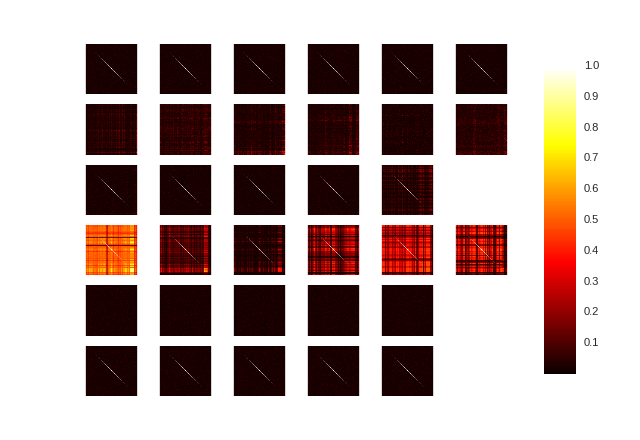

In [166]:
# mean
for test in test_attrs:
    fig, axs = plt.subplots(ncols=len(n_normflows), nrows=len(model_prefixes), sharex=True, sharey=True)
    axs_iter = axs.flat
    for name in model_prefixes:
        for nn in n_normflows:
            ax = next(axs_iter)
            ax.grid(False)
            ax.axis("off")
            try:
                im = ax.imshow(means[test][name][nn],
                               vmax=means_vmax, vmin=means_vmin, cmap=plt.cm.hot) #, norm=Centre()
            except KeyError:  # radialflow has some problems
                pass
            
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
#     fig.tight_layout()
#     plt.axis('off')

<IPython.core.display.Javascript object>


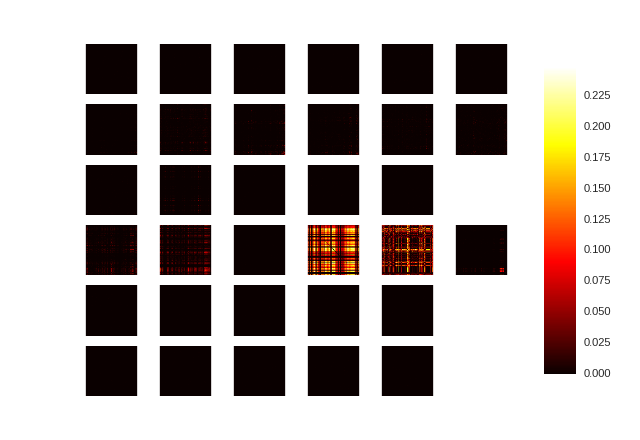

<IPython.core.display.Javascript object>


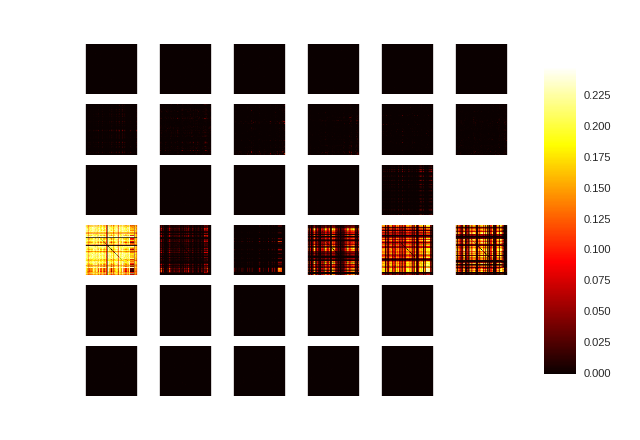

In [167]:
# variances
for test in test_attrs:
    fig, axs = plt.subplots(ncols=len(n_normflows), nrows=len(model_prefixes), sharex=True, sharey=True)
    axs_iter = axs.flat
    for name in model_prefixes:
        for nn in n_normflows:
            ax = next(axs_iter)
            ax.grid(False)
            ax.axis("off")
            try:
                im = ax.imshow(variances[test][name][nn],
                               vmax=variances_vmax, vmin=variances_vmin, cmap=plt.cm.hot)
            except KeyError:  # radialflow has some problems
                pass
            
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
#     fig.tight_layout()
#     plt.axis('off')